# EE4483 Mini Project (Option 2): Cats vs Dogs

Name: Melvin Kok Xinwei
Matriculation Number: U1820030C

## Overview
1. Data exploration
2. Loading and processing data
3. Model selection
4. Model training
5. Model testing
6. CIFAR-10 training
7. CIFAR-10 testing

# Setup environment

In [47]:
import copy
import glob
import os
import random
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from pandas.core.common import flatten
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

%matplotlib inline


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
separator = os.path.sep

In [49]:
params = {
    "lr": 0.001,
    "batch_size": 64,
    "n_epochs": 10,
    "image_size": 224,
    "dropout_rate": 0.5,
}

# 1. Data exploration

Place `datasets` in same directory as notebook

In [50]:
# Define main directories
base_dir = "datasets"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [51]:
# Paths for training images
train_image_paths = []
train_classes = {}

for data_path in glob.glob(train_dir + separator + "*"):
    images = glob.glob(data_path + separator + "*")
    train_classes[data_path.split(separator)[-1]] = len(images)
    train_image_paths.append(images)

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

# Paths for validation images
validation_image_paths = []
validation_classes = {}

for data_path in glob.glob(validation_dir + separator + "*"):
    images = glob.glob(data_path + separator + "*")
    validation_classes[data_path.split(separator)[-1]] = len(images)
    validation_image_paths.append(images)

validation_image_paths = list(flatten(validation_image_paths))
random.shuffle(validation_image_paths)

# Paths for test images
test_image_paths = []
for data_path in glob.glob(test_dir + separator + "*"):
    test_image_paths.append(data_path)

test_image_paths = list(flatten(test_image_paths))

print("train_image_path example: ", train_image_paths[0])
print("validation_image_path example: ", validation_image_paths[0])
print("test_image_path example: ", test_image_paths[0])

train_image_path example:  datasets\train\cat\cat.7784.jpg
validation_image_path example:  datasets\val\cat\cat.4347.jpg
test_image_path example:  datasets\test\1.jpg


In [52]:
for key, value in train_classes.items():
    print(f"Train class {key}, data size {value}")

for key, value in validation_classes.items():
    print(f"Validation class {key}, data size {value}")

print(f"Test size: {len(test_image_paths)}")

Train class cat, data size 10000
Train class dog, data size 10000
Validation class cat, data size 2500
Validation class dog, data size 2500
Test size: 500


# 2. Loading and processing data

In [53]:
# Class to index mappings
idx_to_class = {i:j for i, j in enumerate(train_classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

# Custom Dataset class
class CatDogDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split(separator)[-2]
        label = self.class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [54]:
# Pre-calculated values, use this to save on time
# mean = [0.48846444487571716, 0.45509546995162964, 0.4170514643192291]
# std = [0.23550905287265778, 0.23108406364917755, 0.23146183788776398]

# Get mean and std of dataset
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ]
)

dataset = CatDogDataset(train_image_paths, class_to_idx, transform)

means = []
vars = []
for img, _ in tqdm(dataset):
    means.append(torch.mean(img, [1, 2]))
    vars.append(torch.var(img, [1, 2]))

mean = torch.mean(torch.stack(means), 0)
var = torch.mean(torch.stack(vars), 0)
std = torch.sqrt(var)

mean = mean.tolist()
std = std.tolist()
print(mean)
print(std)

In [55]:
# Image augmentations and pre-processing
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(params["image_size"]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

validation_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((params["image_size"], params["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [56]:
train_dataset = CatDogDataset(train_image_paths, class_to_idx, train_transform)
valid_dataset = CatDogDataset(validation_image_paths, class_to_idx, validation_transform)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=False)

# 3. Model selection

In [59]:
cat_dog_model = torchvision.models.vgg19(pretrained=True)
print(cat_dog_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [60]:
# Freeze layers in model
for param in cat_dog_model.parameters():
    param.requires_grad = False

cat_dog_model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                               torch.nn.ReLU(),
                                               torch.nn.Dropout(p=params["dropout_rate"]),
                                               torch.nn.Linear(4096, 4096),
                                               torch.nn.ReLU(),
                                               torch.nn.Dropout(p=params["dropout_rate"]),
                                               torch.nn.Linear(4096, 2))

# Unfreeze classifier
for param in cat_dog_model.classifier.parameters():
    param.requires_grad = True

model = copy.deepcopy(cat_dog_model)

model.to(device)

probs = torch.nn.Softmax(dim=1)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=params["lr"])

# 4. Model training

In [61]:
train_losses = []
valid_losses = []
valid_acc = []
for epoch in range(params["n_epochs"]):
    # Train
    train_loss = 0.0
    model.train()
    with tqdm(enumerate(train_loader), total=len(train_loader), unit="batch") as pbar:
        for step, (imgs, labels) in pbar:
            pbar.set_description(f"Epoch {epoch+1}/{params['n_epochs']}")

            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            log_preds = model(imgs)
            loss = loss_fn(log_preds, labels)
            loss.backward()

            optimizer.step()

            train_loss += ((1 / (step + 1)) * (loss.data.item() - train_loss))

            pbar.set_postfix(loss=loss.data.item())

    train_losses.append(train_loss)

    # Validation
    valid_loss = 0
    actual_labels = []
    pred_labels = []
    model.eval()
    with tqdm(enumerate(valid_loader), total=len(valid_loader), unit="batch") as pbar:
        for step, (imgs, labels) in pbar:
            pbar.set_description(f"Epoch {epoch+1}/{params['n_epochs']}")  
            imgs, labels = imgs.to(device), labels.to(device)
            log_preds = model(imgs)
            loss = loss_fn(log_preds, labels)
            preds = probs(log_preds)

            valid_loss+=((1 / (step + 1)) * (loss.data.item() - valid_loss))

            # Calculate accuracy
            top_prob, top_class = preds.topk(1, dim=1)
            pred_labels+= list((top_class.view(-1)).cpu().numpy())
            actual_labels+= list(labels.cpu().numpy())

            pbar.set_postfix(loss=loss.data.item())

        correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
        total = len(valid_dataset)
        accuracy = correct / total

        tqdm.write("Epoch {} avg Valid loss: {:.3f}".format(epoch + 1, valid_loss))
        tqdm.write("Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n".format(epoch + 1, accuracy, correct, total))

    valid_losses.append(valid_loss)
    valid_acc.append(accuracy)

    # Save model if validation loss is the lowest
    if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
        torch.save(model.state_dict(), f"models/{params['lr']}_{params['image_size']}_{params['n_epochs']}_{params['dropout_rate']}.pth")

Epoch 1/10: 100%|██████████| 79/79 [00:41<00:00,  1.92batch/s, loss=0.159]


Epoch 1 avg Valid loss: 0.098
Epoch 1 Valid accuracy: 98.3% (4915 of 5000 right)



Epoch 2/10: 100%|██████████| 79/79 [00:38<00:00,  2.06batch/s, loss=0.114]


Epoch 2 avg Valid loss: 0.050
Epoch 2 Valid accuracy: 98.5% (4927 of 5000 right)



Epoch 3/10: 100%|██████████| 79/79 [00:38<00:00,  2.05batch/s, loss=0.108]


Epoch 3 avg Valid loss: 0.038
Epoch 3 Valid accuracy: 98.7% (4937 of 5000 right)



Epoch 4/10: 100%|██████████| 79/79 [00:38<00:00,  2.03batch/s, loss=0.0989]


Epoch 4 avg Valid loss: 0.034
Epoch 4 Valid accuracy: 98.9% (4946 of 5000 right)



Epoch 5/10: 100%|██████████| 79/79 [00:39<00:00,  2.02batch/s, loss=0.0804]


Epoch 5 avg Valid loss: 0.031
Epoch 5 Valid accuracy: 99.0% (4949 of 5000 right)



Epoch 6/10: 100%|██████████| 79/79 [00:39<00:00,  2.00batch/s, loss=0.0496]


Epoch 6 avg Valid loss: 0.030
Epoch 6 Valid accuracy: 99.0% (4949 of 5000 right)



Epoch 7/10: 100%|██████████| 79/79 [00:38<00:00,  2.07batch/s, loss=0.0478]


Epoch 7 avg Valid loss: 0.029
Epoch 7 Valid accuracy: 98.9% (4945 of 5000 right)



Epoch 8/10: 100%|██████████| 79/79 [00:39<00:00,  2.01batch/s, loss=0.045]


Epoch 8 avg Valid loss: 0.028
Epoch 8 Valid accuracy: 98.9% (4946 of 5000 right)



Epoch 9/10: 100%|██████████| 79/79 [00:40<00:00,  1.97batch/s, loss=0.0382]


Epoch 9 avg Valid loss: 0.028
Epoch 9 Valid accuracy: 98.9% (4946 of 5000 right)



Epoch 10/10: 100%|██████████| 79/79 [00:39<00:00,  2.01batch/s, loss=0.0357]


Epoch 10 avg Valid loss: 0.028
Epoch 10 Valid accuracy: 99.0% (4949 of 5000 right)



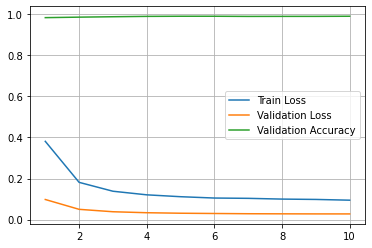

In [62]:
from matplotlib import pyplot as plt
plt.plot(range(1, params["n_epochs"]+1), train_losses, label="Train Loss")
plt.plot(range(1, params["n_epochs"]+1), valid_losses, label="Validation Loss")
plt.plot(range(1, params["n_epochs"]+1), valid_acc, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# 5. Model testing

In [63]:
model.load_state_dict(torch.load(f"models/{params['lr']}_{params['image_size']}_{params['n_epochs']}_{params['dropout_rate']}.pth"))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Validation set

In [64]:
# Validation
running_loss = 0
actual_labels = []
pred_labels = []
with tqdm(enumerate(valid_loader), total=len(valid_loader), unit="batch") as pbar:
    for step, (imgs, labels) in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        log_preds = model(imgs)
        loss = loss_fn(log_preds, labels)

        preds = probs(log_preds)
        running_loss += ((1 / (step + 1)) * (loss.data.item() - running_loss))

        # Calculate accuracy
        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels += list((top_class.view(-1)).cpu().numpy())
        actual_labels += list(labels.cpu().numpy())

        pbar.set_postfix(loss=loss.data.item())

    correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
    total = len(actual_labels)
    accuracy = correct / total

    tqdm.write("Valid loss: {:.3f}".format(running_loss))
    tqdm.write("Valid accuracy: {:.1%} ({} of {} right)\n".format(accuracy, correct, total))

100%|██████████| 79/79 [00:38<00:00,  2.06batch/s, loss=0.0357]

Valid loss: 0.028
Valid accuracy: 99.0% (4949 of 5000 right)



## Test set

In [65]:
# Custom Dataset class for test data
class TestCatDogDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image_filename = Path(image_filepath).stem
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image)

        return image, image_filename

In [66]:
test_dataset = TestCatDogDataset(test_image_paths, validation_transform)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)

In [67]:
# Test
pred_labels = []
filename = []
with tqdm(test_loader, total=len(test_loader), unit="batch") as pbar:
    for imgs, filenames in pbar:
        imgs = imgs.to(device)
        log_preds = model(imgs)

        preds = probs(log_preds)

        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels += list((top_class.view(-1)).cpu().numpy())
        filename += filenames

100%|██████████| 500/500 [00:06<00:00, 73.13batch/s]


In [68]:
df = pd.DataFrame(list(zip(filename, pred_labels)),
               columns=["id", "label"])
df["id"] = pd.to_numeric(df["id"])
df = df.sort_values(by=["id"])
df.to_csv("submission.csv", index=False)

# 6. CIFAR-10 training

In [69]:
train_transform = transforms.Compose(
    [
        transforms.Resize((params["image_size"], params["image_size"])),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

validation_transform = transforms.Compose(
    [
        transforms.Resize((params["image_size"], params["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [70]:
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform=train_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params["batch_size"],
                                          shuffle=True,
                                          num_workers=params["num_workers"])

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=validation_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params["batch_size"],
                                         shuffle=False, num_workers=params["num_workers"])

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [71]:
model = copy.deepcopy(cat_dog_model)
model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=params["dropout_rate"]),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=params["dropout_rate"]),
                                       torch.nn.Linear(4096, 10))
model.to(device)

probs = torch.nn.Softmax(dim=1)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=params["lr"])

In [72]:
train_losses = []
valid_losses = []
valid_acc = []
for epoch in range(params["n_epochs"]):
    # Train
    train_loss = 0.0
    model.train()
    with tqdm(enumerate(train_loader), total=len(train_loader), unit="batch") as pbar:
        for step, (imgs, labels) in pbar:
            pbar.set_description("Epoch {}/{}".format(epoch+1, params["n_epochs"]))

            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            log_preds = model(imgs)
            loss = loss_fn(log_preds, labels)
            loss.backward()

            optimizer.step()

            train_loss += ((1 / (step + 1)) * (loss.data.item() - train_loss))

            pbar.set_postfix(loss=loss.data.item())
    train_losses.append(train_loss)

    # Validation
    valid_loss = 0
    actual_labels = []
    pred_labels = []
    model.eval()
    with tqdm(enumerate(test_loader), total=len(test_loader), unit="batch") as pbar:
        for step, (imgs, labels) in pbar:
            pbar.set_description(f"Epoch {epoch+1}/{params['n_epochs']}")  
            imgs, labels = imgs.to(device), labels.to(device)
            log_preds = model(imgs)
            loss = loss_fn(log_preds, labels)

            preds = probs(log_preds)
            valid_loss+=((1 / (step + 1)) * (loss.data.item() - valid_loss))

            # Calculate accuracy
            top_prob, top_class = preds.topk(1, dim=1)
            pred_labels+= list((top_class.view(-1)).cpu().numpy())
            actual_labels+= list(labels.cpu().numpy())

            pbar.set_postfix(loss=loss.data.item())

        correct = (np.array(pred_labels)==np.array(actual_labels)).sum()
        total = len(actual_labels)
        accuracy = correct / total

        tqdm.write("Epoch {} avg Valid loss: {:.3f}".format(epoch + 1, valid_loss))
        tqdm.write("Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n".format(epoch + 1, accuracy, correct, total))

    valid_losses.append(valid_loss)
    valid_acc.append(accuracy)

    if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
        torch.save(model.state_dict(), f"models/cifar_10_{params['lr']}_{params['image_size']}_{params['n_epochs']}_{params['dropout_rate']}.pth")

Epoch 1/10: 100%|██████████| 157/157 [00:47<00:00,  3.32batch/s, loss=1.61]


Epoch 1 avg Valid loss: 1.543
Epoch 1 Valid accuracy: 68.6% (6857 of 10000 right)



Epoch 2/10: 100%|██████████| 157/157 [00:46<00:00,  3.35batch/s, loss=0.879]


Epoch 2 avg Valid loss: 0.899
Epoch 2 Valid accuracy: 76.6% (7656 of 10000 right)



Epoch 3/10: 100%|██████████| 157/157 [00:45<00:00,  3.44batch/s, loss=0.633]


Epoch 3 avg Valid loss: 0.670
Epoch 3 Valid accuracy: 79.4% (7944 of 10000 right)



Epoch 4/10: 100%|██████████| 157/157 [00:46<00:00,  3.39batch/s, loss=0.513]


Epoch 4 avg Valid loss: 0.568
Epoch 4 Valid accuracy: 81.6% (8156 of 10000 right)



Epoch 5/10: 100%|██████████| 157/157 [00:45<00:00,  3.42batch/s, loss=0.42]


Epoch 5 avg Valid loss: 0.516
Epoch 5 Valid accuracy: 83.0% (8300 of 10000 right)



Epoch 6/10: 100%|██████████| 157/157 [00:46<00:00,  3.41batch/s, loss=0.385]


Epoch 6 avg Valid loss: 0.479
Epoch 6 Valid accuracy: 83.7% (8374 of 10000 right)



Epoch 7/10: 100%|██████████| 157/157 [00:46<00:00,  3.40batch/s, loss=0.368]


Epoch 7 avg Valid loss: 0.455
Epoch 7 Valid accuracy: 84.2% (8425 of 10000 right)



Epoch 8/10: 100%|██████████| 157/157 [00:47<00:00,  3.33batch/s, loss=0.335]


Epoch 8 avg Valid loss: 0.436
Epoch 8 Valid accuracy: 84.8% (8483 of 10000 right)



Epoch 9/10: 100%|██████████| 157/157 [00:46<00:00,  3.41batch/s, loss=0.321]


Epoch 9 avg Valid loss: 0.422
Epoch 9 Valid accuracy: 85.6% (8556 of 10000 right)



Epoch 10/10: 100%|██████████| 157/157 [00:46<00:00,  3.34batch/s, loss=0.3]


Epoch 10 avg Valid loss: 0.411
Epoch 10 Valid accuracy: 85.9% (8587 of 10000 right)



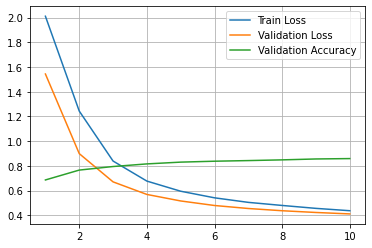

In [73]:
from matplotlib import pyplot as plt
plt.plot(range(1, params["n_epochs"]+1), train_losses, label="Train Loss")
plt.plot(range(1, params["n_epochs"]+1), valid_losses, label="Validation Loss")
plt.plot(range(1, params["n_epochs"]+1), valid_acc, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# 7. CIFAR-10 testing

In [74]:
model.load_state_dict(torch.load(f"models/cifar_10_{params['lr']}_{params['image_size']}_{params['n_epochs']}_{params['dropout_rate']}.pth"))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [75]:
# Test
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
model.eval()

with tqdm(test_loader, total=len(test_loader), unit="batch") as pbar:
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        log_preds = model(imgs)
        loss = loss_fn(log_preds, labels)

        preds = probs(log_preds)

        top_prob, top_class = preds.topk(1, dim=1)

        for label, prediction in zip(labels, top_class):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

100%|██████████| 157/157 [00:47<00:00,  3.32batch/s]


In [76]:
print(correct_pred)
print(total_pred)

{'plane': 864, 'car': 929, 'bird': 777, 'cat': 735, 'deer': 844, 'dog': 808, 'frog': 908, 'horse': 882, 'ship': 926, 'truck': 914}
{'plane': 1000, 'car': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


In [77]:
# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

correct = sum(correct_pred.values())
total = sum(total_pred.values())
accuracy = correct / total

print("Test accuracy: {:.1%} ({} of {} right)\n".format(accuracy, correct, total))

Accuracy for class plane is: 86.4 %
Accuracy for class car   is: 92.9 %
Accuracy for class bird  is: 77.7 %
Accuracy for class cat   is: 73.5 %
Accuracy for class deer  is: 84.4 %
Accuracy for class dog   is: 80.8 %
Accuracy for class frog  is: 90.8 %
Accuracy for class horse is: 88.2 %
Accuracy for class ship  is: 92.6 %
Accuracy for class truck is: 91.4 %
Test accuracy: 85.9% (8587 of 10000 right)

